<a href="https://colab.research.google.com/github/musicjae/cs231n/blob/master/assignment2/The_Understanding_of_the_FC_net_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. assignment2 마운트

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment2/cs231n/datasets
/content


In [14]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving st0.png to st0.png
User uploaded file "st0.png" with length 8621 bytes


In [15]:
from IPython.display import Image

## 1. 전연결 신경망 in cs231n assignment2

임의의 개수의 은닉층, ReLU 활성화, 소프트맥스 손실 함수, 드롭아웃과 배치/레이어 정규화를 가진 전연결 신경망을 코딩해보자. 
  
  (affine - [batch/layer norm] - relu - [dropout]) x (L - 1) - affine - softmax  
    
    

여기서 배치/레이어 정규화와 드롭아웃은 선택적이다. 학습 가능한 모수는 self.params 딕셔너리에 저장하고, solver class를 사용하여 이것을 학습시켜라.

**Inputs:**  
- **hidden_dims:** A list of integers giving the size of each hidden layer.
- **input_dim:** An integer giving the size of the input.
- **num_classes:** An integer giving the number of classes to classify.
- **dropout:** giving dropout strength, 0~1의 스칼라. If dropout=1 then dropout 사용 x.

- **normalization**: What type of normalization the network should use. Valid values are "batchnorm", "layernorm", or None for no normalization (the default).
- **reg**: Scalar giving L2 regularization strength.
-**weight_scale**:  가중치의 랜덤 초기화의 표준 편차를 제공해주는 스칼라
- **dtype**:  A numpy datatype object; all computations will be performed using this datatype. float32 is faster but less accurate, so you should use float64 for numeric gradient checking.

- **seed**: If seed = None, then this random seed ==pass==> dropout layers. This will make the dropout layers deteriminstic, so we can gradient check the model.

### 1.1 스택stack  
  
  필자는 이 글을 작성하고 있는 현 시점에서 스택을 처음 써본다. 그래서 간략히 이것에 대해 알아본다.

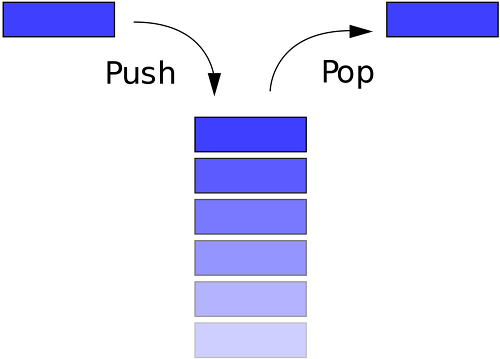

In [16]:
Image('st0.png')

스택은 마지막에 들어간 것이 처음으로 나온다. 이른바, 후입선출이다. 스택의 마지막 항에 어떤 요소를 넣을 때, push를 사용하고, 그것을 뺄 때는 pop을 사용한다. is_empty를 통해 스택이 비어있는지를 확인한다. 아래 코드에서 사용할 hstack 에 대해 알아보자. 이것은 스택을 횡렬로 쌓는 것이다.

In [67]:
import numpy as np

mat1 = np.random.randn(2,3)
mat2 = np.random.randn(2,3)

print(mat1,'\n\n',mat2,'\n\n')
print(np.hstack((mat1,mat2)))

dims = np.hstack((2,3,4))
print(dims)

[[ 1.99535561 -1.06874509 -0.97035768]
 [ 0.55826868  2.27020101 -0.98206229]] 

 [[ 0.85231377 -0.09285112 -0.2800965 ]
 [-0.4065982  -0.74166892 -1.08910321]] 


[[ 1.99535561 -1.06874509 -0.97035768  0.85231377 -0.09285112 -0.2800965 ]
 [ 0.55826868  2.27020101 -0.98206229 -0.4065982  -0.74166892 -1.08910321]]
[2 3 4]


In [9]:
from builtins import range
from builtins import object
import numpy as np

from cs231n.layers import *
from cs231n.layer_utils import *



class FullyConnectedNet(object):

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
        use_batchnorm=False
    ):


        self.use_batchnorm = use_batchnorm
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        """ 
        모든 값을 self.params 딕셔너리에 저장하면서, 연결망의 모수를 초기화하라. 가중치는 표준 정규 분포로
        초기화되어야 하고, bias는 0으로 초기화되어야 한다.

        배치 정규화 사용 시, 스케일, 쉬프트 모수를 감마, 베타에 저장하라. 스케일 모수는 1로 쉬프트 모수는 0으로
        초기화 하라.

        """

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dims = np.hstack((input_dim, hidden_dims, num_classes)) # 차원을 스택을 이용해서 만든 것 뿐이다.

        for i in range(self.num_layers):
            self.params['W%d' % (i + 1)] = weight_scale * np.random.randn(dims[i], dims[i+1])
            self.params['b%d' % (i + 1)] = np.zeros(dims[i+1])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################

        """
        드롭아웃 사용 시, 우리는 layer가 드롭아웃_확률과 그 mode(학습/테스트)를 알게 하기 위해
        <드롭아웃_모수 딕셔너리>를 --> <각 드롭아웃 레이어>로 보낼 필요가 있다.
        """


        self.dropout_param = {} # dropout 모수 초기화.
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout}
            if seed is not None:
                self.dropout_param["seed"] = seed


        """
        배치 정규화를 가지고서, 우리는 평균, 분산을 추적할 필요가 있고, 따라서 특별한 bn_param 객체를
        각 배치 정규화 layer로 보낼 필요가 있다. 당신은 self.bn_params[0]를 1st 배치 정규화 층의
        순전파로 보낼 필요가 있고, self.bn_params[1]를 2nd 배치 정규화의 순전파로 보낼 필요가 있다.
        """

        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype) # 형변환
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None

        """
        (1) X의 클래스 스코어 계산하고 그것을 스코어 변수에 저장하면서, fcnet의 순전파 수행
        (2) 드롭아웃 사용 시, self.dropout_param을 각 드롭아웃 순전파에 통과시켜야
        (3) 배치 정규화 사용시, self.bn_params[0]을 첫 번째 배치 정규화 레이어의 순전파에 통과시키고,
        self.bn_params[1]을 두번째 배치 정규화 레이어에 통과 시켜 ... 
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        hidden_num = self.num_layers - 1
        scores = X
        cache_history = []
        L2reg = 0
        for i in range(hidden_num):
            if self.use_batchnorm:
                scores, cache = affine_bn_relu_forward(scores,
                                                      self.params['W%d' % (i + 1)],
                                                      self.params['b%d' % (i + 1)],
                                                      self.params['gamma%d' % (i + 1)],
                                                      self.params['beta%d' % (i + 1)],
                                                      self.bn_params[i])
            else:
                scores, cache = affine_relu_forward(scores, self.params['W%d' % (i + 1)],
                                                            self.params['b%d' % (i + 1)])
            cache_history.append(cache)
            if self.use_dropout:
                scores, cache = dropout_forward(scores, self.dropout_param)
                cache_history.append(cache)
            L2reg += np.sum(self.params['W%d' % (i + 1)] ** 2)
        i += 1
        scores, cache = affine_forward(scores, self.params['W%d' % (i + 1)],
                                               self.params['b%d' % (i + 1)])
        cache_history.append(cache)
        L2reg += np.sum(self.params['W%d' % (i + 1)] ** 2)
        L2reg *= 0.5 * self.reg

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == "test":
            return scores

        loss, grads = 0.0, {}

        """
        전연결망의 역전파를 수행하라. 손실 변수는 loss에 그래디언트는 grads 딕셔너리에 넣어라. 
        소프트맥스를 사용하여 데이터를 계산하고 grads[k]가 self.params[k]의 grads에 성립하게 만들어라.
        L2정규화도 해라.
        
        배치/레이어 정규화 시, 파라미터 정규화할 필요 없다.
        
        주의: L2 정규화는 0.5로 써라.        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dout = softmax_loss(scores, y)
        loss += L2reg

        dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)] = affine_backward(dout, cache_history.pop())
        grads['W%d' % (i + 1)] += self.reg * self.params['W%d' % (i + 1)]
        i -= 1
        while i >= 0:
            if self.use_dropout:
                dout = dropout_backward(dout, cache_history.pop())
            if self.use_batchnorm:
                dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)], grads['gamma%d' % (i + 1)], grads['beta%d' % (i + 1)] = affine_bn_relu_backward(dout, cache_history.pop())
            else:
                dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)] = affine_relu_backward(dout, cache_history.pop())
            grads['W%d' % (i + 1)] += self.reg * self.params['W%d' % (i + 1)]
            i -= 1
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [13]:
import numpy as np
a = np.random.randn(3,2)
b = np. random.randn(3,2)

c= np.hstack((a,b))
print(c.shape)

(3, 4)
